In [11]:
import os
import torch
from PIL import Image, ImageTk
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import clip
import matplotlib.pyplot as plt
import torch.nn.functional as F


def preprocess(image):
    transform = Compose([
        Resize(224, interpolation=3),
        CenterCrop(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(image)


def preprocess_images(image_paths, model, device):
    image_features = []
    for path in image_paths:
        image = Image.open(path).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model.encode_image(image_tensor)
        features = features.flatten()
        image_features.append(features.cpu().numpy())
    return np.stack(image_features)


def search(query, image_paths, model, device):
    text = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
        image_features = preprocess_images(image_paths, model, device)

        if not isinstance(text_features, torch.Tensor):
            text_features = torch.from_numpy(text_features).to(device)
        if not isinstance(image_features, torch.Tensor):
            image_features = torch.from_numpy(image_features).to(device)
        cosine_similarity = F.cosine_similarity(text_features, image_features, dim=-1)
        
    values, indices = cosine_similarity.topk(5)
    results = [(image_paths[idx], values[i].item()) for i, idx in enumerate(indices)]
    return results


model, preprocess = clip.load('ViT-B/32', device='cpu')

In [12]:
def plot_results(results):
    for image_path, score in results:
        # Load the image using PIL
        img = Image.open(image_path)

        # Plot the image
        plt.imshow(img)
        plt.title(f'Similarity Score: {score:.4f}')
        plt.axis('off')
        plt.show()

In [13]:
image_paths = [os.path.join("animals/", filename) for filename in os.listdir("animals/") if filename.endswith((".jpg",".png"))]

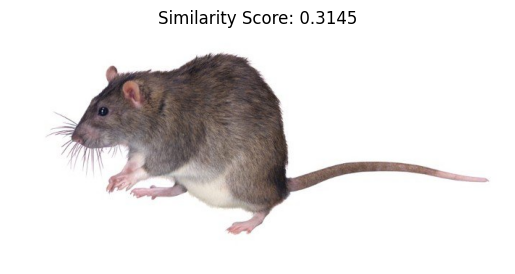

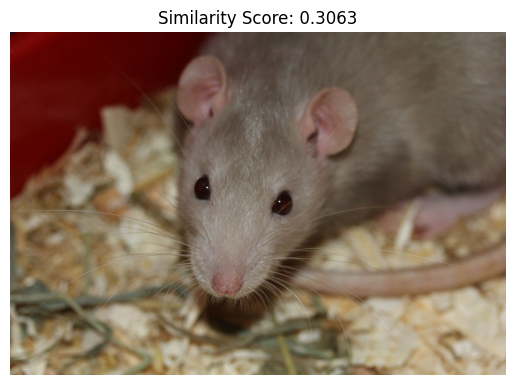

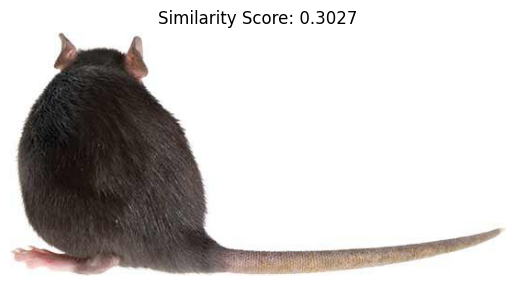

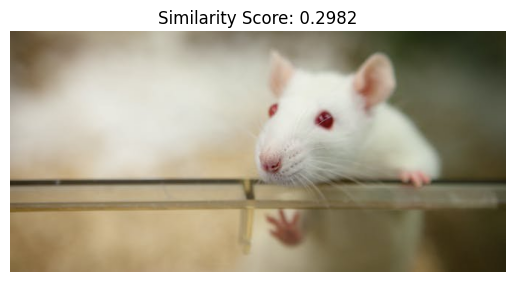

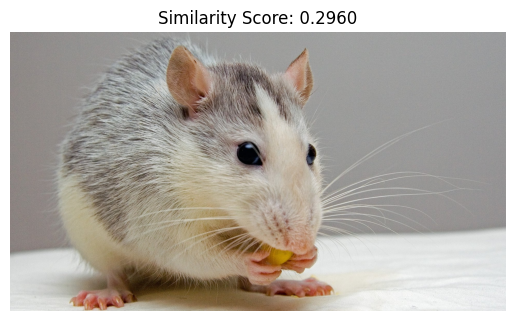

In [14]:
results = search("rat", image_paths, model, "cpu")
plot_results(results)

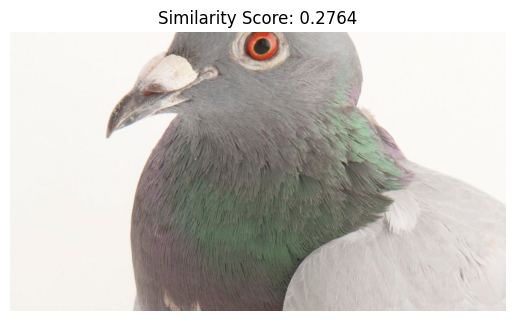

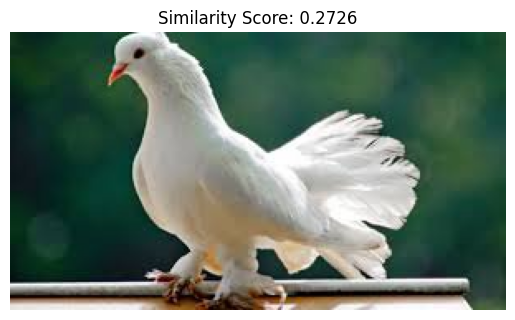

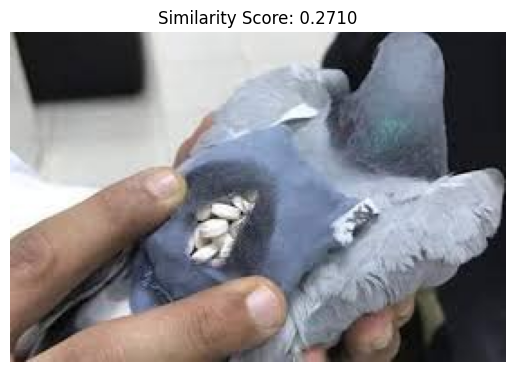

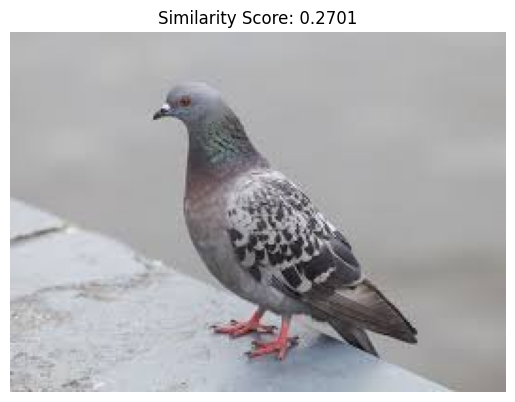

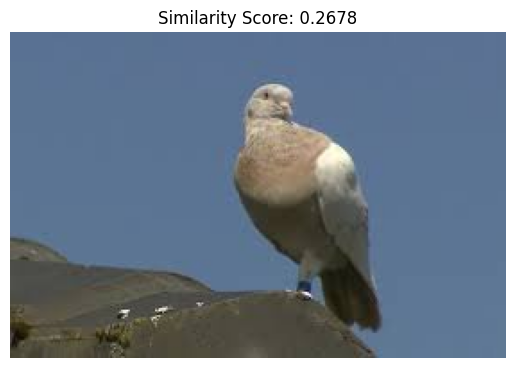

In [15]:
results = search("bird", image_paths, model, "cpu")
plot_results(results)

In [16]:
descriptions = {
    "0a5f5db460": "tiger",
    "0cf320e7de": "starfish",
    "4ad3fbedde": "snake",
    "4b038131a9": "rat",
    "3c4d9be7a3": "bird",
    "0f43a8237e": "wolf",
    "0aad5539de": "sheep", 
    "2c9e747589": "turtle"
}

In [17]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("animals") if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join("animals", filename)).convert("RGB")

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

<Figure size 1600x500 with 0 Axes>

In [18]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])
     

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [19]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

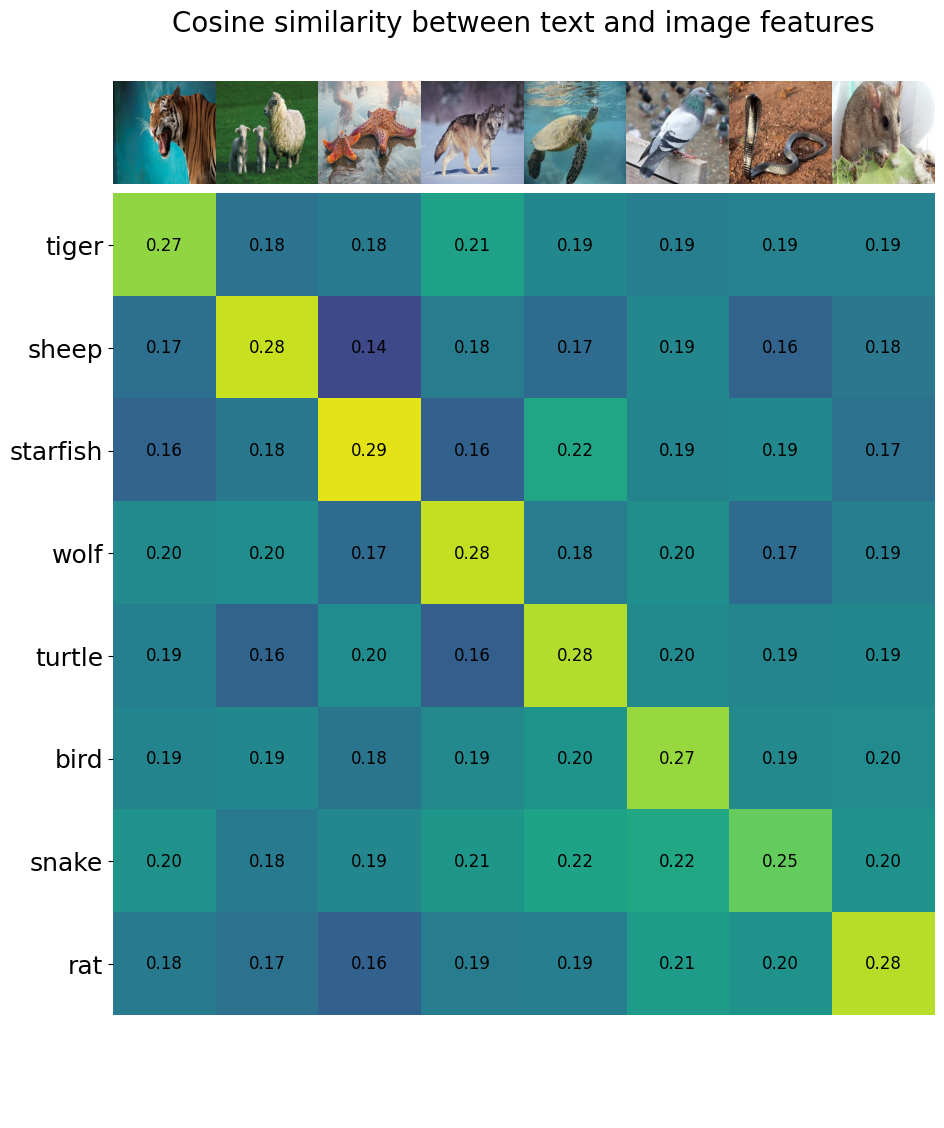

In [20]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)